In [6]:
from os import listdir
from perception import hashers
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src.config import DATA_DIR

hasher = hashers.PHashF()
TRAIN_DIR = DATA_DIR / "raw" / "phishIRIS_DL_Dataset/train"

img_to_hash = dict()
hash_to_img = dict()
img_per_company = defaultdict(list)
hash_to_company = defaultdict()

for company in listdir(TRAIN_DIR):
    if company in [".DS_Store", "other"]:
        continue

    for example in listdir(TRAIN_DIR / company):
        file_path = TRAIN_DIR / company / example
        hsh = hasher.compute(str(file_path))
        img_to_hash["-".join(example.split(" "))] = hasher.string_to_vector(hsh)
        hash_to_img[hsh] = "-".join(example.split(" "))
        hash_to_company[hsh] = company
        img_per_company[company].append(hsh)

In [2]:
def print_hash(hsh):
    h = hashers.PHashF().string_to_vector(hsh)
    for x in h:
        print("1" if x else "0", end="")


def get_hash(file_path):
    h = hashers.PHashF()
    return h.compute(file_path)

In [7]:
kmeans = KMeans(n_clusters=14, init="k-means++", n_init="auto")
clusters = kmeans.fit(list(img_to_hash.values()))
data_transformed = kmeans.transform(list(img_to_hash.values()))

In [16]:
clusters

KMeans(n_clusters=14)

In [51]:
len(
    hashers.PHashF().string_to_vector(
        "gMt2STyhjMVEhIrFK7NBxQIupEU/N55EcmxHRbx+V0W6bf3FvMMKxlPy0cQXz6REtWvtw6QhrEXDXQNFyEyoRIxJzsQtUrJCIJNaxNR5G8Rf6kNEesf2w0dsXkR/Z8TCquDwRP7/2kR4KE5E41i6QngIEsXzLqvEDXThxJ8Th8SByCbEX/pYRaF4RcLjOzPEO1jJxDD5LsW2/MfEPFmuxPN2skPoxJRFl4Klw5MV0sQLKbHCivCFxWgTn8QOMMTDvWGERRv6nMQo1HhEfU/IQ3EjP8UjAGtCw2ggxSZIg0OeAEbF3iYBRWJyHMNC0dbEhTnYRBaA5sSPnq5DTYUHRA=="
    )
)

64

In [5]:
x, y, z = (
    get_hash("phishIRIS_DL_Dataset/val/adobe/adobe_test (1).png"),
    get_hash("phishIRIS_DL_Dataset/val/boa/boa_test (1).png"),
    get_hash("phishIRIS_DL_Dataset/val/apple/apple_test (2).png"),
)

In [14]:
(
    kmeans.predict([hasher.string_to_vector(x)]),
    kmeans.predict([hasher.string_to_vector(y)]),
    kmeans.predict([hasher.string_to_vector(z)]),
)

(array([0], dtype=int32), array([9], dtype=int32), array([13], dtype=int32))

In [7]:
clusters.labels_[2], hash_to_img[hasher.vector_to_string(list(img_to_hash.values())[2])]

(2, 'apple-(6).png')

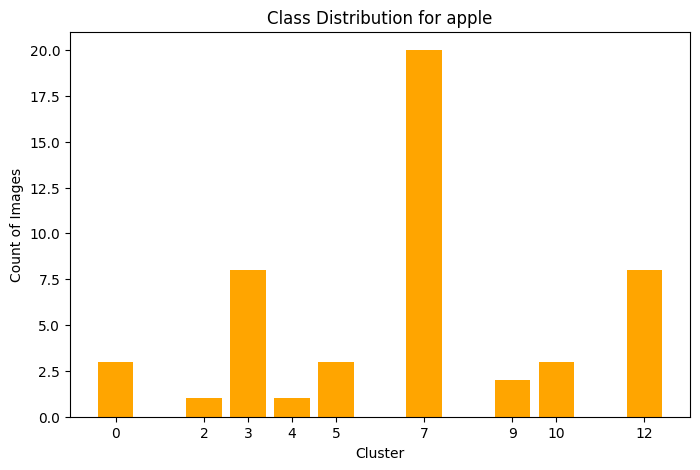

apple:  {0.0: 3, 2.0: 1, 3.0: 8, 4.0: 1, 5.0: 3, 7.0: 20, 9.0: 2, 10.0: 3, 12.0: 8}


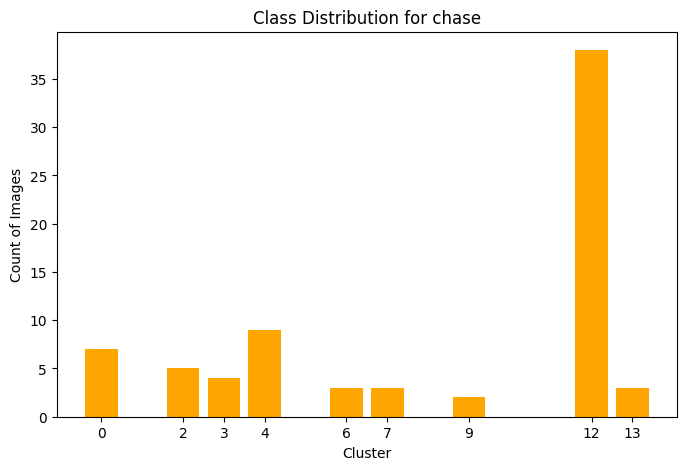

chase:  {0.0: 7, 2.0: 5, 3.0: 4, 4.0: 9, 6.0: 3, 7.0: 3, 9.0: 2, 12.0: 38, 13.0: 3}


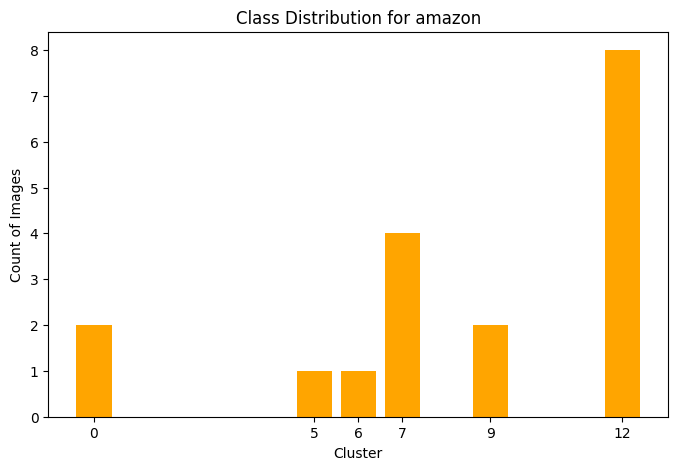

amazon:  {0.0: 2, 5.0: 1, 6.0: 1, 7.0: 4, 9.0: 2, 12.0: 8}


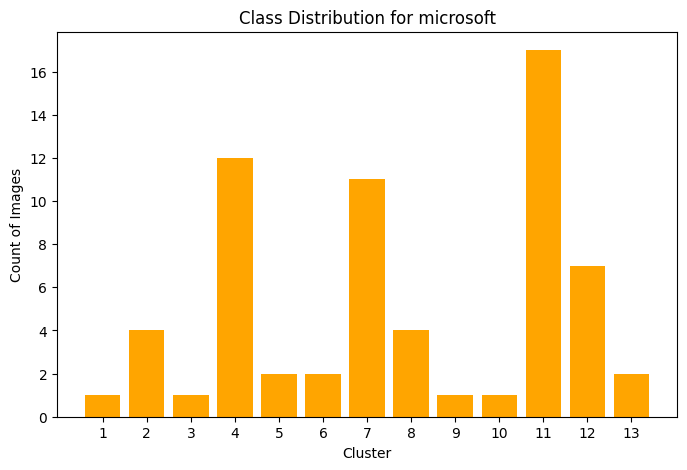

microsoft:  {1.0: 1, 2.0: 4, 3.0: 1, 4.0: 12, 5.0: 2, 6.0: 2, 7.0: 11, 8.0: 4, 9.0: 1, 10.0: 1, 11.0: 17, 12.0: 7, 13.0: 2}


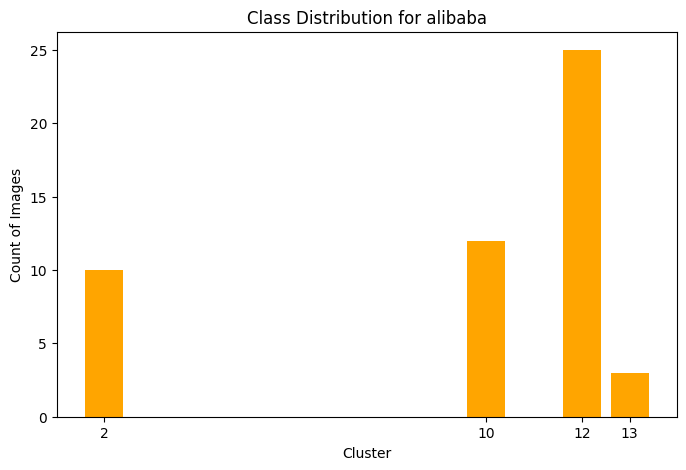

alibaba:  {2.0: 10, 10.0: 12, 12.0: 25, 13.0: 3}


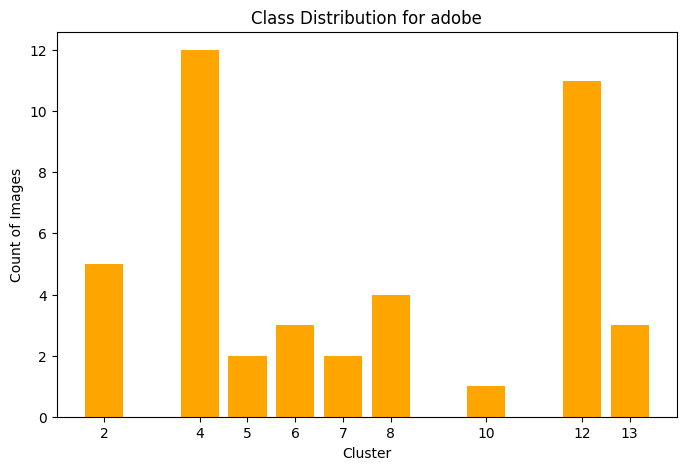

adobe:  {2.0: 5, 4.0: 12, 5.0: 2, 6.0: 3, 7.0: 2, 8.0: 4, 10.0: 1, 12.0: 11, 13.0: 3}


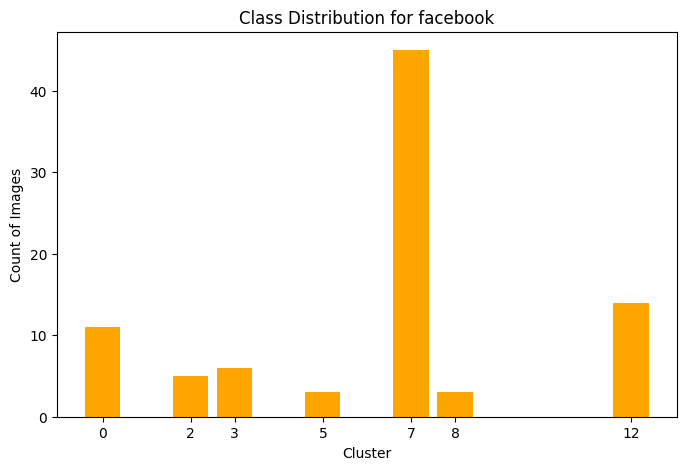

facebook:  {0.0: 11, 2.0: 5, 3.0: 6, 5.0: 3, 7.0: 45, 8.0: 3, 12.0: 14}


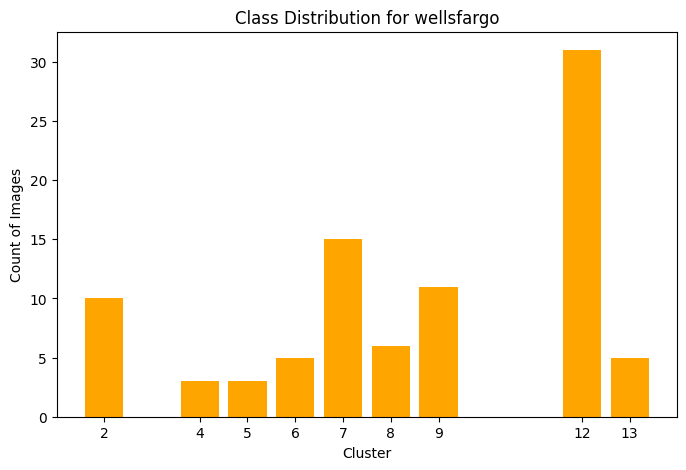

wellsfargo:  {2.0: 10, 4.0: 3, 5.0: 3, 6.0: 5, 7.0: 15, 8.0: 6, 9.0: 11, 12.0: 31, 13.0: 5}


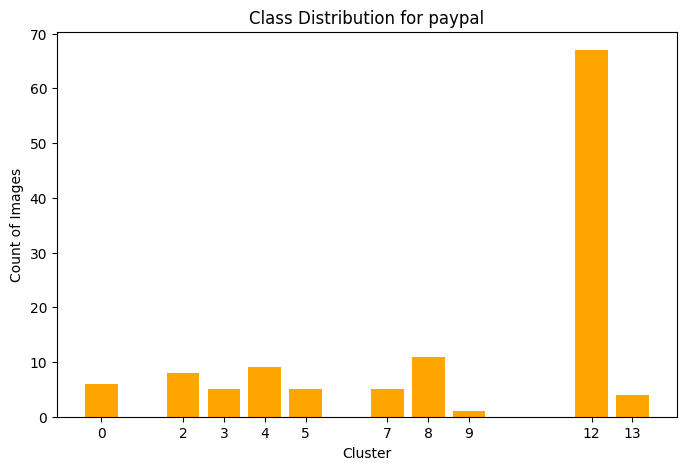

paypal:  {0.0: 6, 2.0: 8, 3.0: 5, 4.0: 9, 5.0: 5, 7.0: 5, 8.0: 11, 9.0: 1, 12.0: 67, 13.0: 4}


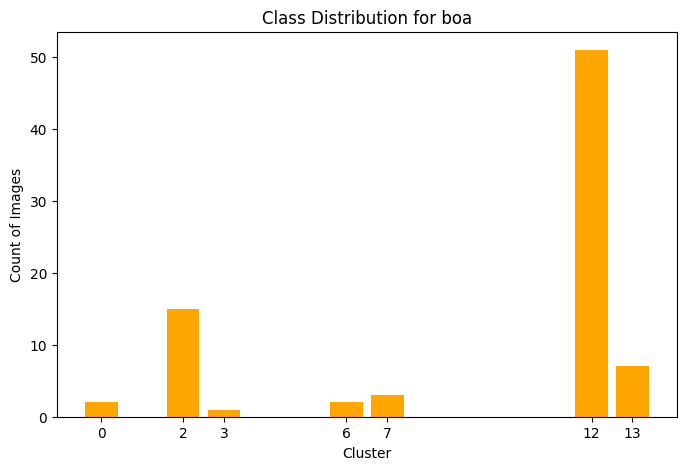

boa:  {0.0: 2, 2.0: 15, 3.0: 1, 6.0: 2, 7.0: 3, 12.0: 51, 13.0: 7}


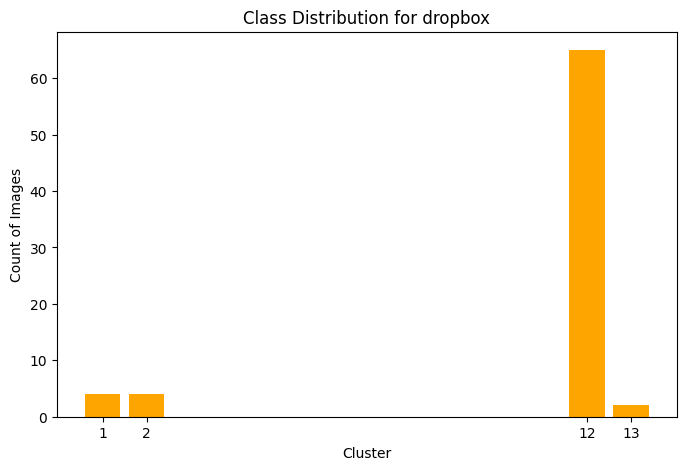

dropbox:  {1.0: 4, 2.0: 4, 12.0: 65, 13.0: 2}


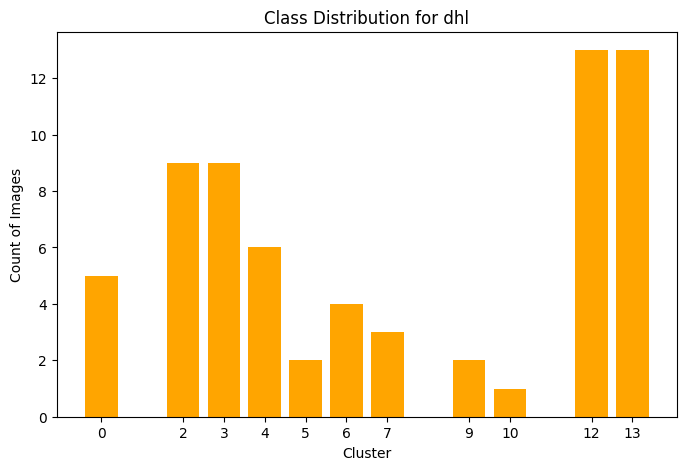

dhl:  {0.0: 5, 2.0: 9, 3.0: 9, 4.0: 6, 5.0: 2, 6.0: 4, 7.0: 3, 9.0: 2, 10.0: 1, 12.0: 13, 13.0: 13}


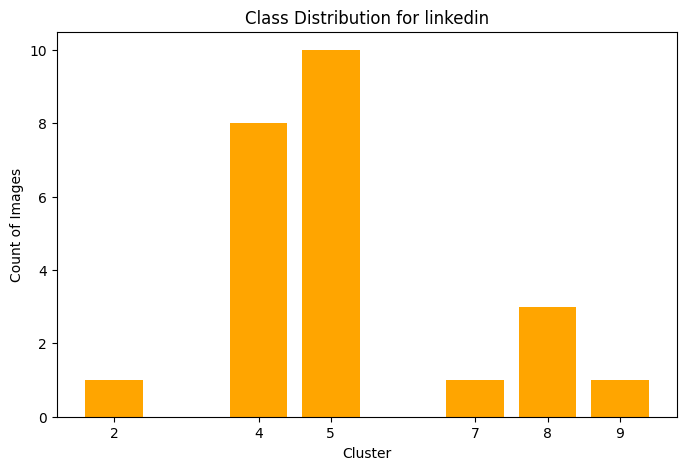

linkedin:  {2.0: 1, 4.0: 8, 5.0: 10, 7.0: 1, 8.0: 3, 9.0: 1}


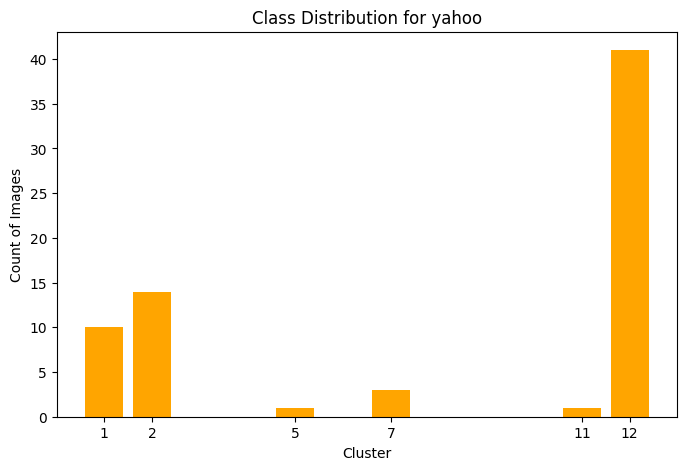

yahoo:  {1.0: 10, 2.0: 14, 5.0: 1, 7.0: 3, 11.0: 1, 12.0: 41}


In [8]:
"""
# TODO: wypisz dominujaca klase z kazdego klastra
# dict klasa -> nr klastra
# jakies metryczki z TP, TN, FP, FN i inne z scikit learna
# popraw kod xD

for company, imgs in img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(kmeans.predict([hasher.string_to_vector(hash_of_img)]))
    unique, counts = np.unique(predicted_class, return_counts=True)
    print(f'{company}: ', dict(zip(unique, counts)))
    print('='*10)
    
"""
for company, imgs in img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(
            kmeans.predict([hasher.string_to_vector(hash_of_img)])[0]
        )

    # Get the unique classes and their counts
    unique, counts = np.unique(predicted_class, return_counts=True)

    # Create a bar plot for this company
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color="orange")
    plt.xlabel("Cluster")
    plt.ylabel("Count of Images")
    plt.title(f"Class Distribution for {company}")
    plt.xticks(unique)
    plt.show()

    print(f"{company}: ", dict(zip(unique, counts)))
    print("=" * 10)

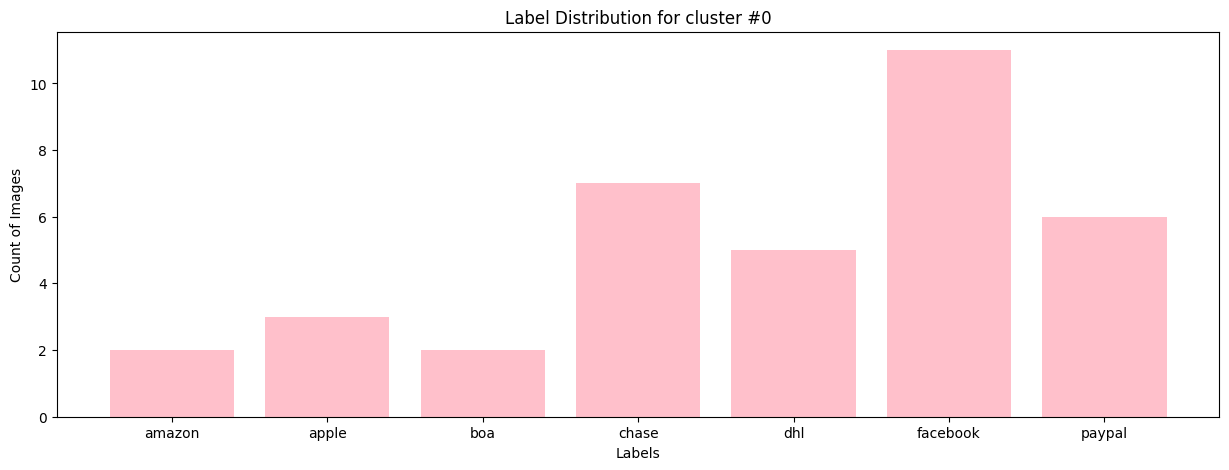

Cluster #0 Labels:  {'amazon': 2, 'apple': 3, 'boa': 2, 'chase': 7, 'dhl': 5, 'facebook': 11, 'paypal': 6}


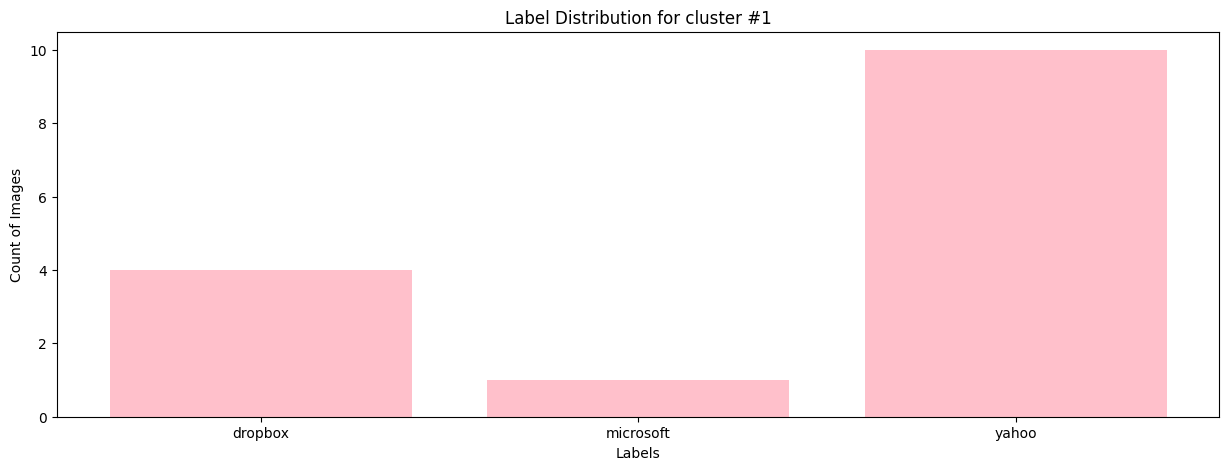

Cluster #1 Labels:  {'dropbox': 4, 'microsoft': 1, 'yahoo': 10}


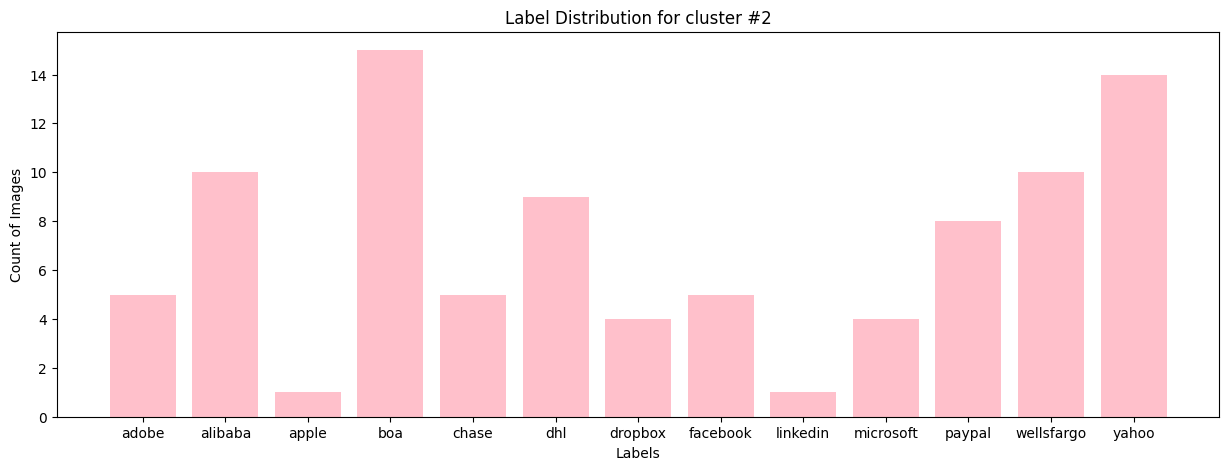

Cluster #2 Labels:  {'adobe': 5, 'alibaba': 10, 'apple': 1, 'boa': 15, 'chase': 5, 'dhl': 9, 'dropbox': 4, 'facebook': 5, 'linkedin': 1, 'microsoft': 4, 'paypal': 8, 'wellsfargo': 10, 'yahoo': 14}


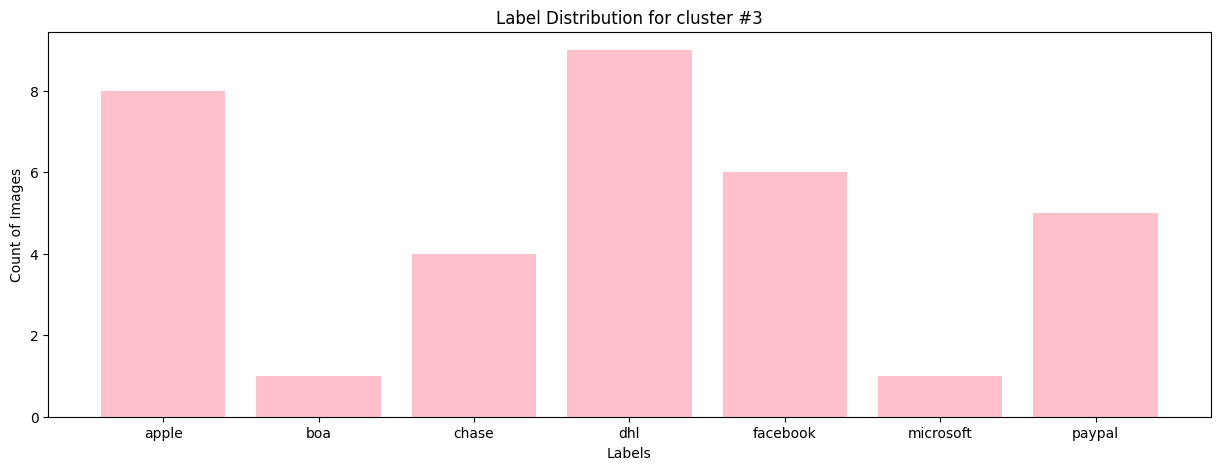

Cluster #3 Labels:  {'apple': 8, 'boa': 1, 'chase': 4, 'dhl': 9, 'facebook': 6, 'microsoft': 1, 'paypal': 5}


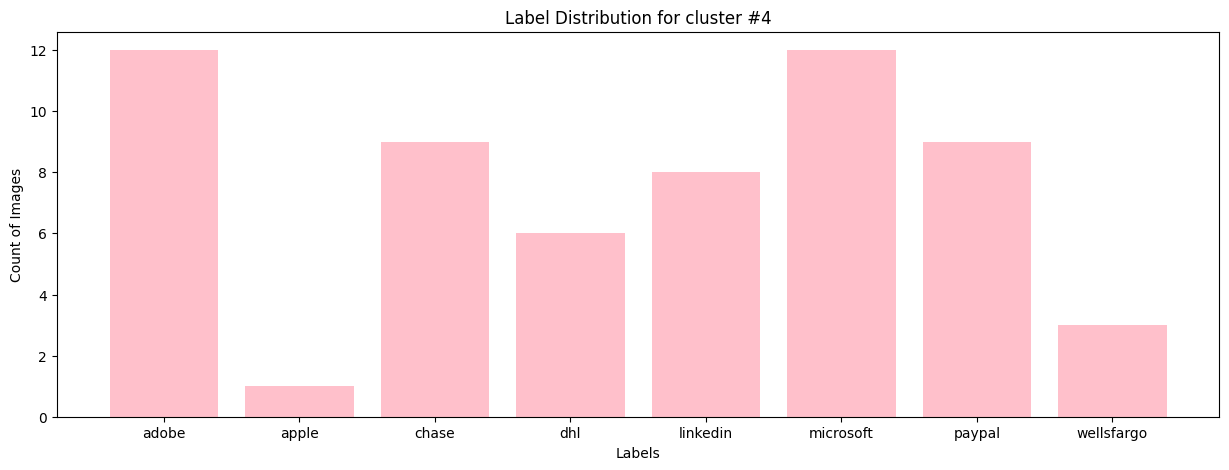

Cluster #4 Labels:  {'adobe': 12, 'apple': 1, 'chase': 9, 'dhl': 6, 'linkedin': 8, 'microsoft': 12, 'paypal': 9, 'wellsfargo': 3}


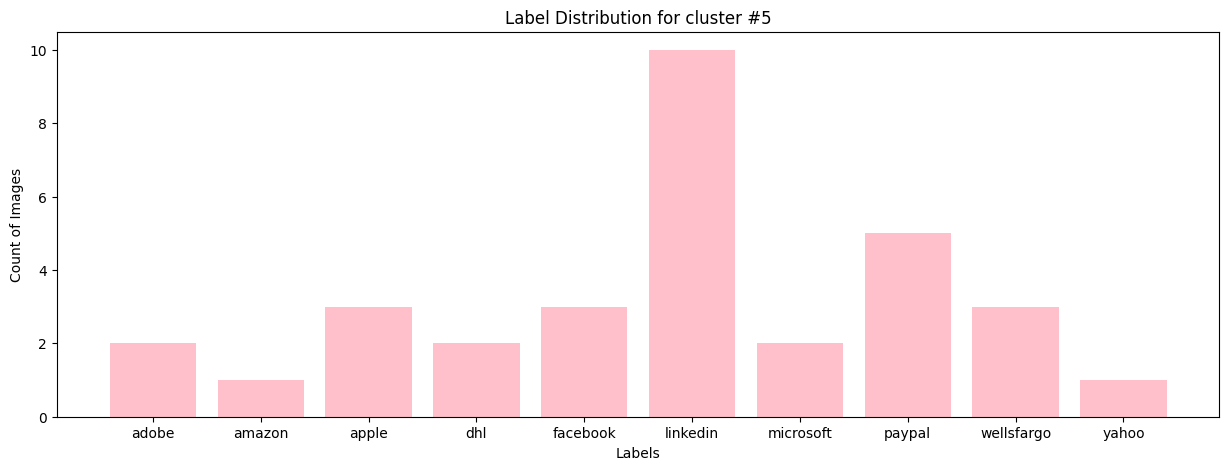

Cluster #5 Labels:  {'adobe': 2, 'amazon': 1, 'apple': 3, 'dhl': 2, 'facebook': 3, 'linkedin': 10, 'microsoft': 2, 'paypal': 5, 'wellsfargo': 3, 'yahoo': 1}


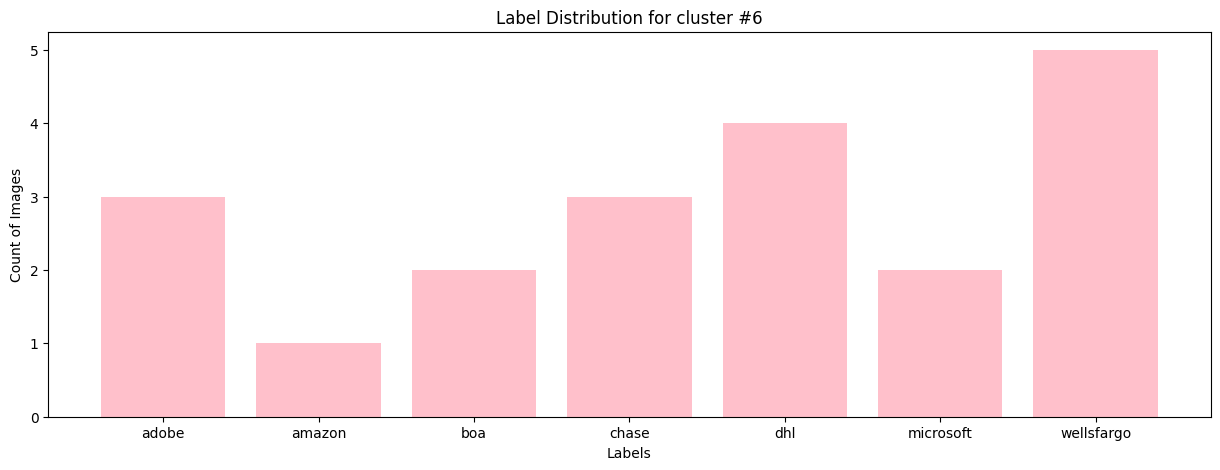

Cluster #6 Labels:  {'adobe': 3, 'amazon': 1, 'boa': 2, 'chase': 3, 'dhl': 4, 'microsoft': 2, 'wellsfargo': 5}


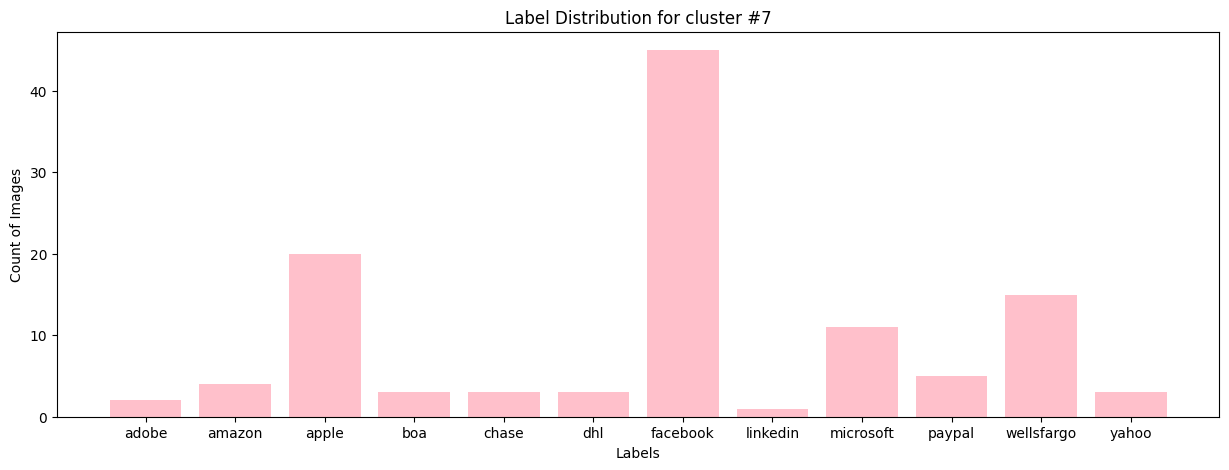

Cluster #7 Labels:  {'adobe': 2, 'amazon': 4, 'apple': 20, 'boa': 3, 'chase': 3, 'dhl': 3, 'facebook': 45, 'linkedin': 1, 'microsoft': 11, 'paypal': 5, 'wellsfargo': 15, 'yahoo': 3}


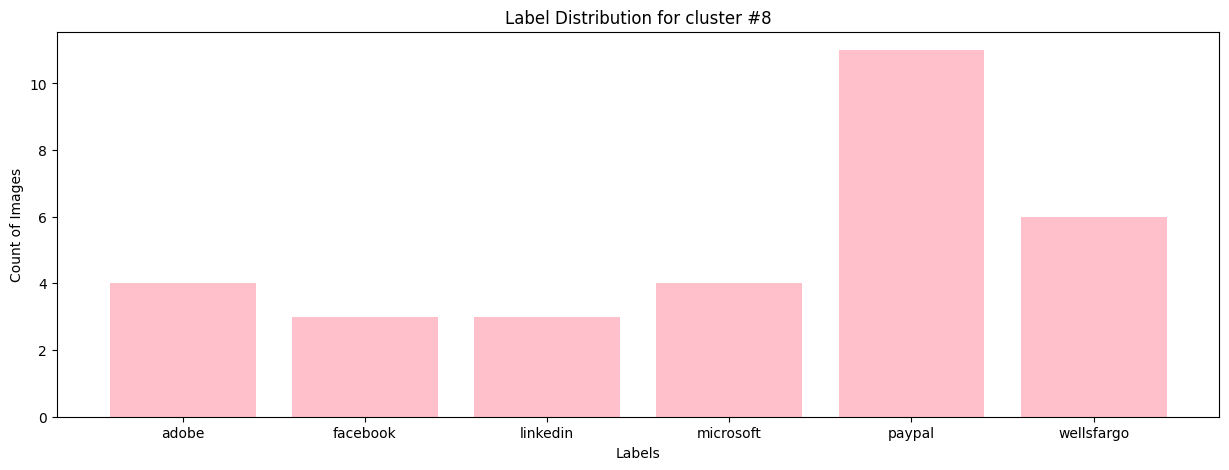

Cluster #8 Labels:  {'adobe': 4, 'facebook': 3, 'linkedin': 3, 'microsoft': 4, 'paypal': 11, 'wellsfargo': 6}


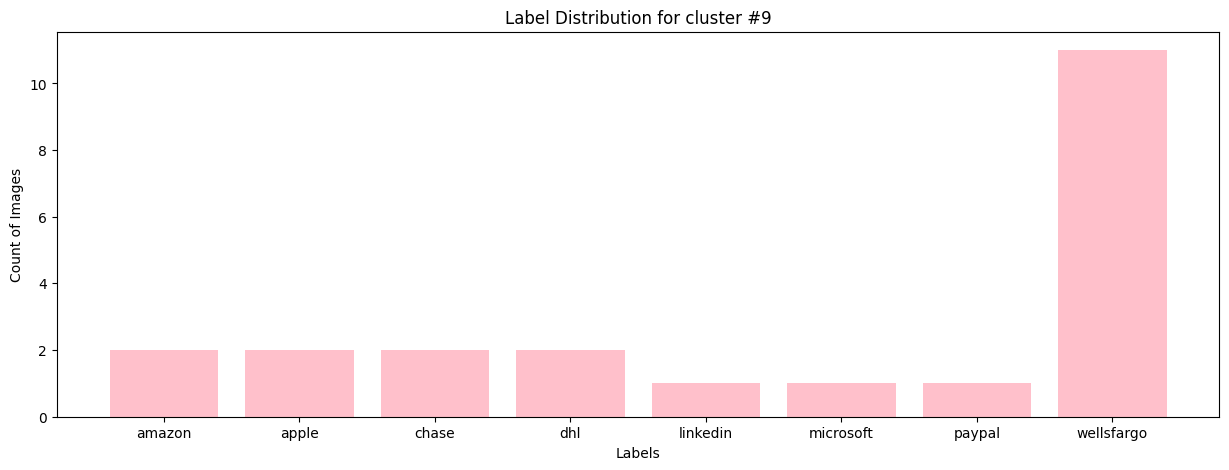

Cluster #9 Labels:  {'amazon': 2, 'apple': 2, 'chase': 2, 'dhl': 2, 'linkedin': 1, 'microsoft': 1, 'paypal': 1, 'wellsfargo': 11}


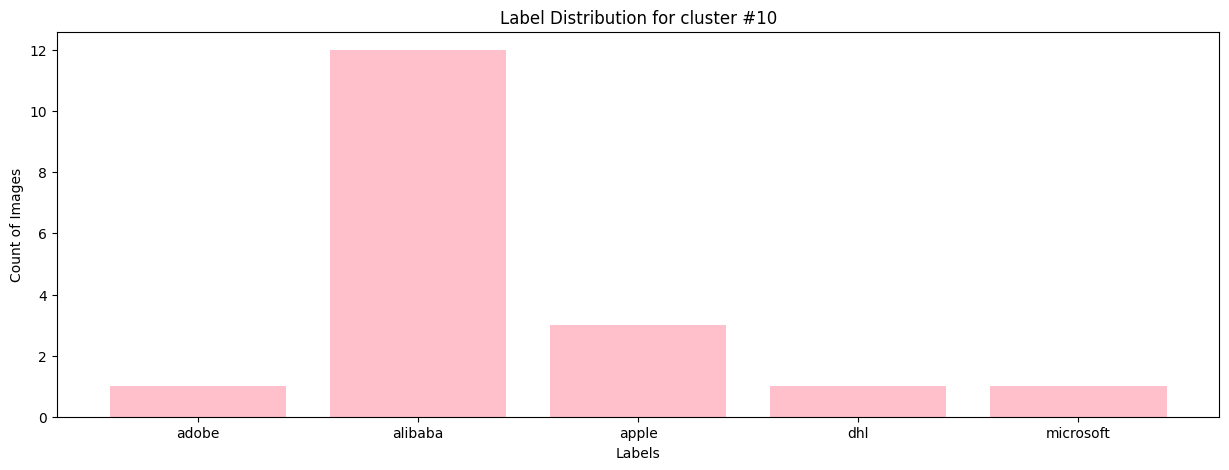

Cluster #10 Labels:  {'adobe': 1, 'alibaba': 12, 'apple': 3, 'dhl': 1, 'microsoft': 1}


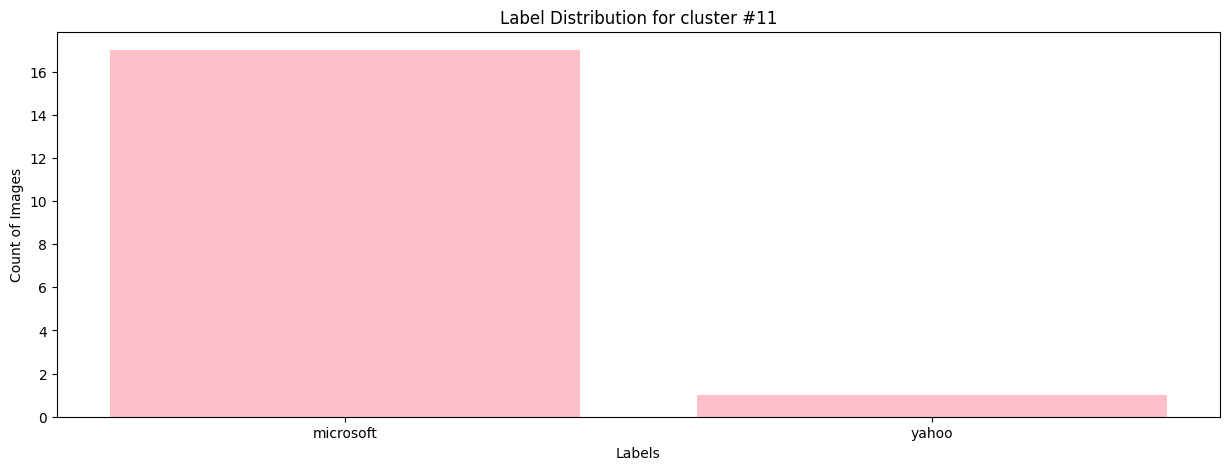

Cluster #11 Labels:  {'microsoft': 17, 'yahoo': 1}


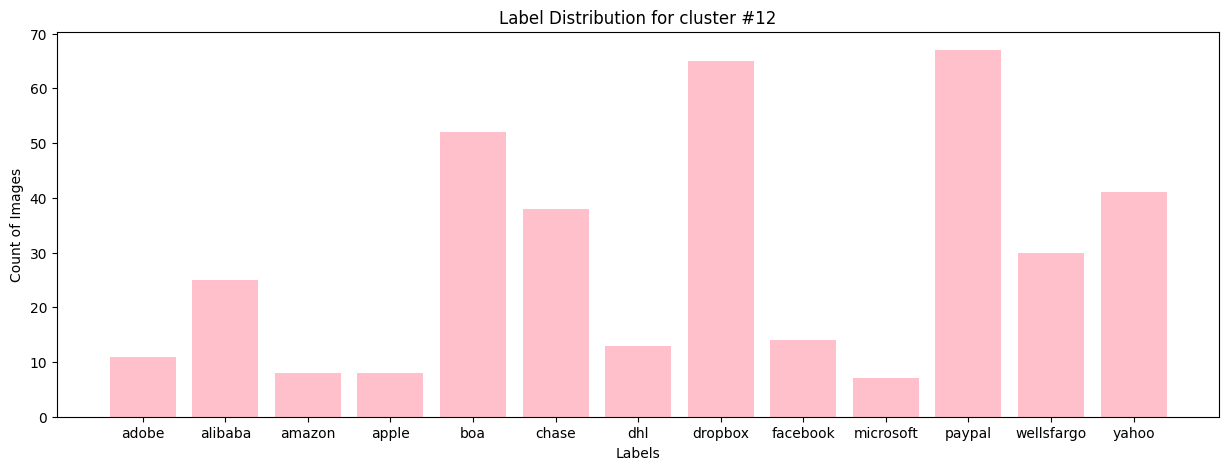

Cluster #12 Labels:  {'adobe': 11, 'alibaba': 25, 'amazon': 8, 'apple': 8, 'boa': 52, 'chase': 38, 'dhl': 13, 'dropbox': 65, 'facebook': 14, 'microsoft': 7, 'paypal': 67, 'wellsfargo': 30, 'yahoo': 41}


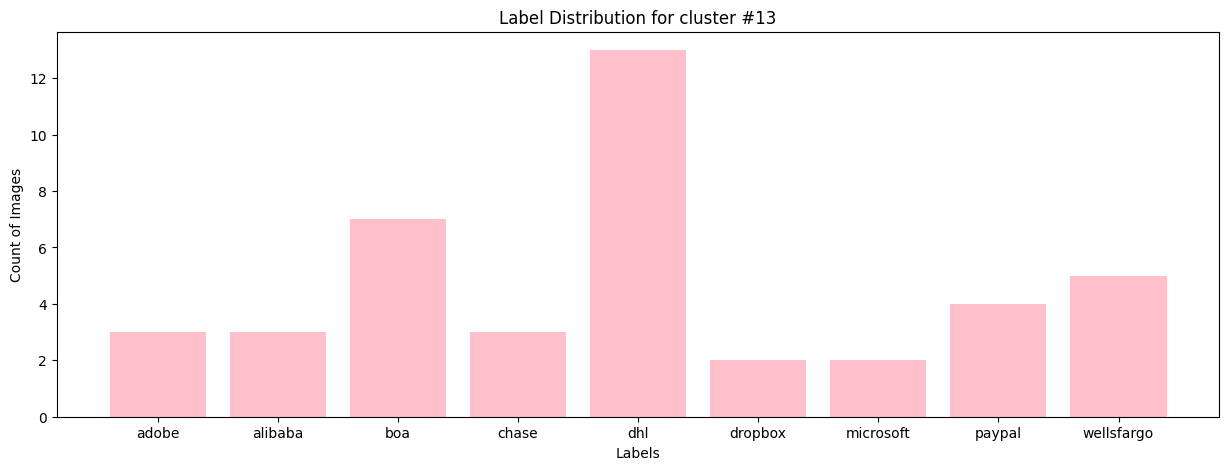

Cluster #13 Labels:  {'adobe': 3, 'alibaba': 3, 'boa': 7, 'chase': 3, 'dhl': 13, 'dropbox': 2, 'microsoft': 2, 'paypal': 4, 'wellsfargo': 5}


In [9]:
cluster_to_hash = defaultdict(list)
for idx, (img_name, img_hash) in enumerate(img_to_hash.items()):
    cluster_to_hash[kmeans.labels_[idx]].append(hasher.vector_to_string(img_hash))

for idx in range(clusters.n_clusters):
    labels = []
    for x in cluster_to_hash[idx]:
        labels.append(hash_to_company[x])
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Create a bar plot for the labels of this company
    plt.figure(figsize=(15, 5))
    plt.bar(unique_labels, label_counts, color="pink")
    plt.xlabel("Labels")
    plt.ylabel("Count of Images")
    plt.title(f"Label Distribution for cluster #{idx}")
    plt.xticks(unique_labels)
    plt.show()

    print(f"Cluster #{idx} Labels: ", dict(zip(unique_labels, label_counts)))
    print("=" * 10)

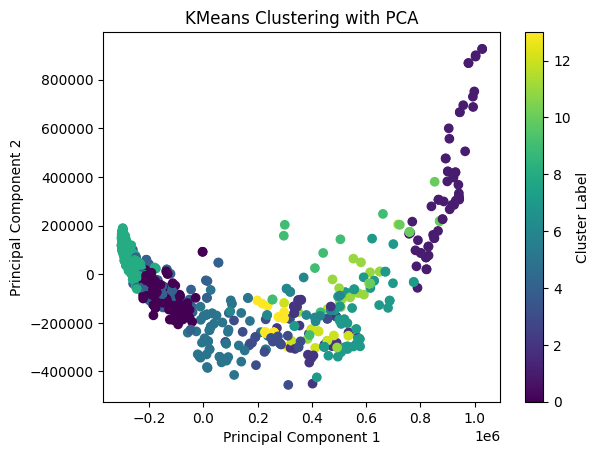

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_transformed)

# Visualize the
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters.labels_, cmap="viridis")
plt.title("PCA on clustered data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()